<a href="https://colab.research.google.com/github/SalmanRafiullah/garbage-classification/blob/master/InceptionV3_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Garbage classification:** InceptionV3

## Installing libraries

In [0]:
#Import necessary libraries
from keras.applications.inception_v3 import InceptionV3
from keras_preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras import optimizers, losses
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import pickle
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from google.colab import drive
import os



Using TensorFlow backend.


## Data preparation

### Mount Drive

In [0]:
#Mount Google Drive
drive.mount('/content/drive')
""
#Assign directory path for test, train and validation data
test_data_dir = '/content/drive/My Drive/split-garbage-dataset/split-garbage-dataset/test'
train_data_dir = '/content/drive/My Drive/split-garbage-dataset/split-garbage-dataset/train'
valid_data_dir = '/content/drive/My Drive/split-garbage-dataset/split-garbage-dataset/valid'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load data as ImageDataGenerator and images

In [0]:
#Define dictionary and reverse dictionary
LABELS = ["trash", "plastic", "paper", "metal", "glass", "cardboard"]

LABELS_NUMBERS_MAP = {k:v for k,v in zip(LABELS, range(len(LABELS)))}
LABELS_NUMBERS_REVERSE ={v: k for k, v in LABELS_NUMBERS_MAP.items()}

In [0]:
#Load train images from directory
train_generator = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1. / 255,
        shear_range=0.1,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=40,
    ).flow_from_directory(
        directory=train_data_dir,
        target_size=(300, 300),
        class_mode = 'categorical',
    )

#Load validation images from directory
valid_generator = ImageDataGenerator(
        rescale=1 / 255,
    ).flow_from_directory(
        directory=valid_data_dir,
        target_size=(300, 300),
        class_mode = 'categorical',
    )

#Load test images from test directory
test_generator = ImageDataGenerator(
        rescale=1 / 255,
    ).flow_from_directory(
        directory=test_data_dir,
        target_size=(300, 300),
        class_mode = 'categorical',
    )

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


In [0]:
LOAD_FILES_FROM_DRIVE = False


import numpy as np
from skimage.io import imread_collection

#LOAD_FILES_FROM_DRIVE = True

if not LOAD_FILES_FROM_DRIVE:
    for path in [train_data_dir, valid_data_dir, test_data_dir]:
        image_list = [
            imread_collection(f"{path}/{label}/*.jpg") for label in LABELS
        ]
        X_tmp = np.concatenate(image_list)
        y_tmp = np.concatenate([
            np.full(len(arr), i) for i, arr in enumerate(image_list)
        ])
        data_type = path.split("/")[-1]
        np.save(f"X_{data_type}.npy", X_tmp)
        np.save(f"y_{data_type}.npy", y_tmp)

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_valid = np.load("X_valid.npy")
y_valid = np.load("y_valid.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

## Understanding the data

### Visualize sample photos

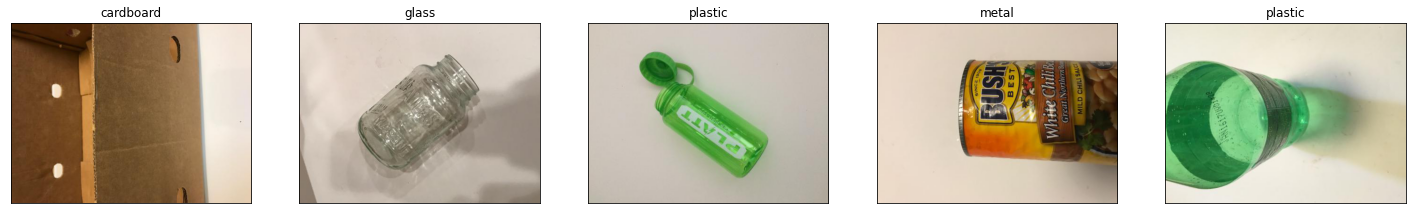

In [0]:
#Pending code for visualizing sample photos
import matplotlib.pyplot as plt
#fig, axes = plt.subplots(1,5)
plt.figure(figsize=[25,15])

for k,i in enumerate(np.random.randint(0, len(X_train), 5)):
    plt.subplot(1,5,k+1)
    plt.imshow(X_train[i])
    plt.xticks(())
    plt.yticks(())
    plt.title(LABELS_NUMBERS_REVERSE[y_train[i]])
    #plt.show()

## Build model

### Define layers

In [0]:
#Install tf-nightly
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
  
import tensorflow as tf


#Define model to train the data on
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))
#Loading pretrained weights as Trasnsfer Learning fro Inception V3
#https://www.kaggle.com/careyai/inceptionv3-full-pretrained-model-instructions
base_model.load_weights('/content/drive/My Drive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
base_model.trainable = False
#Defining layers for model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    #Conv2D(1024,3, strides = 2, padding="same", activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.15),
    #Flatten(),
    Dense(6, activation='softmax')
])

     |████████████████████████████████| 533.1MB 23kB/s 
     |████████████████████████████████| 2.9MB 35.4MB/s 
     |████████████████████████████████| 2.8MB 32.4MB/s 
     |████████████████████████████████| 460kB 22.2MB/s 
     |████████████████████████████████| 778kB 22.1MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Compile model

In [0]:
#Define optimizer and learning rate
opt = optimizers.nadam(lr=0.001)
#Compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
#Print model summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 6150      
Total params: 23,907,110
Trainable params: 2,104,326
Non-trainable params: 21,802,784
________________________________

### Train the model

In [0]:
batch_size = 200
epochs = 200
patience = 10

steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

filepath = "/content/drive/My Drive/model/model_{epoch:02d}-{acc:.2f}-{val_acc:.2f}.h5"
#filepath = "model_{epoch:02d}.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
checkpoint2 = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

rlrp = ReduceLROnPlateau(monitor='acc', factor=0.1, patience=patience, min_delta=0.000000001)

callbacks_list = [rlrp,checkpoint1,checkpoint2]

In [0]:
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
8/8 [==============================] - 102s 13s/step - loss: 2.5360 - acc: 0.2188 - val_loss: 1.5229 - val_acc: 0.5000

Epoch 00001: saving model to /content/drive/My Drive/model/model_01-0.22-0.50.h5

Epoch 00001: acc improved from -inf to 0.21875, saving model to /content/drive/My Drive/model/model_01-0.22-0.50.h5
Epoch 2/200
8/8 [==============================] - 89s 11s/step - loss: 1.6254 - acc: 0.4062 - val_loss: 1.3391 - val_acc: 0.5000

Epoch 00002: saving model to /content/drive/My Drive/model/model_02-0.41-0.50.h5

Epoch 00002: acc improved from 0.21875 to 0.40625, saving model to /content/drive/My Drive/model/model_02-0.41-0.50.h5
Epoch 3/200
8/8 [==============================] - 88s 11s/step - loss: 1.3395 - acc: 0.4883 - val_loss: 1.0134 - val_acc: 0.6562

Epoch 00003: saving model to /content/drive/My Drive/model/model_03-0.49-0.66.h5

Epoch 00003: acc improved fro

In [0]:
#Download History as CSV to local drive
from google.colab import files
import pandas as pd

hist_df = pd.DataFrame(history.history) 
hist_df.to_csv('trainHistoryDict.csv')
files.download('trainHistoryDict.csv')

## Test the model

In [0]:
#Define model to train the data on
test_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))
test_model.trainable = False
#Defining layers for model
model1 = Sequential([
    test_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    #Conv2D(1024,3, strides = 2, padding="same", activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    #Flatten(),
    Dense(6, activation='softmax')
])

In [0]:
model1.load_weights('/content/drive/My Drive/model_198-0.88.h5')

In [0]:
#Define optimizer and learning rate
opt = optimizers.nadam(lr=1.00E-18)
#Compile the model
model1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])



In [0]:
history1=model1.evaluate_generator(test_generator)

In [0]:
from keras.models import load_model 
model1 = load_model('/content/drive/My Drive/model_93-0.81.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
history1=model1.evaluate_generator(test_generator)

KeyboardInterrupt: ignored

In [0]:
history1

In [0]:
Y_pred = model.predict_generator(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))